<h1>VISUAL RECOGNITION OF IMAGES FROM SNAPSHOT SERENGETI DATASET USING DEEP LEARNING METHODS</h1> by Sergey Volchkov

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten,  MaxPooling2D, Conv2D
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

F:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import os
import csv
import cv2

Is the network to be trained or to be used for predictions only?

In [3]:
PREDICT_ONLY=True

Set the image folder and path to the file containing the labels:

In [4]:
if PREDICT_ONLY:
    image_folder = "./images"
else:
    root_folder = r"F:\images"
    image_folder = os.path.join(root_folder, "resized96")
label_file = os.path.join(image_folder, "data.csv")

 Set the fraction of images to be assigned to train dataset:

In [5]:
train_test_split = 0.9

Load images and labels:

In [19]:
# Read list of images from image directory
images = [os.path.splitext(x)[0] for x in os.listdir(image_folder) if x.endswith(".jpg")]

# Read .csv with data
data_dict = None
with open(label_file) as file:
    data_dict = list(csv.reader(file))[1:]
data_dict = {x[0]:int(x[1]) for x in data_dict}

# Checking that the list of images and the list of data are the same
images = [x for x in images if x in data_dict]  
data_dict = {x:data_dict[x] for x in data_dict if x in set(images)}



def read_images(data, image_folder):
    image_list = []
    for f in data:
        filename = str(f) + ".jpg"
        fullname = os.path.join(image_folder,filename)
        img = cv2.imread(fullname)
        image_list.append(img)
    return np.stack(image_list,axis = 3)

if PREDICT_ONLY:
    X_test = read_images(images, image_folder)
    y_test = to_categorical(np.array([data_dict[x] for x in images])[:,np.newaxis])
else:
    total_images = len(data_dict)
    train_size = round(total_images * train_test_split)
    test_size = total_images - train_size
    print("Train data size: ",train_size)
    print("Test data size: ", test_size)
    
    RANDOM = True

    if RANDOM:
        import random
        test_indices = random.sample(range(total_images), test_size)
        train_indices = [x for x in range(total_images) if x not in test_indices]
        train_data = [images[i] for i in train_indices]
        test_data = [images[i] for i in test_indices]
    else:
        train_data = images[:train_size]
        test_data = images[train_size:]

 

    X_train = read_images(train_data, image_folder)
    X_test = read_images(test_data, image_folder)
    y_train = to_categorical(np.array([data_dict[x] for x in train_data]))
    y_test = to_categorical(np.array([data_dict[x] for x in test_data])[:,np.newaxis])

    print("Train array shape: ",X_train.shape)
    print("Test array shape: ", X_test.shape)
    print("Train label array shape: ",y_train.shape)
    print("Test label array shape: ", y_test.shape)

Preparing images for loading into network, including image normalisation:

In [20]:
if not PREDICT_ONLY:
    X_train = X_train.transpose(3, 0, 1, 2)
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    train_mean = np.mean(X_train, axis=0)
    train_std = np.std(X_train, axis=0)
    X_train -= train_mean.astype('float32')
    X_train /= (train_std + 1e-7).astype('float32')

X_test = X_test.transpose(3, 0, 1, 2)

X_test = X_test.astype('float32')

X_test = X_test / 255.0

test_mean = np.mean(X_test, axis=0)
test_std = np.std(X_test, axis=0)
X_test -= test_mean.astype('float32')
X_test /= (test_std + 1e-7).astype('float32')

n_classes = 2

Create image data generator for data augmentation:

In [21]:
if not PREDICT_ONLY:
    from keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

    train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32)

    test_generator = train_datagen.flow(
    X_test, y_test,
    batch_size=32)

Either load the network from file (in prediction-only mode) or create the network:

In [22]:
from keras import regularizers
if PREDICT_ONLY:
    from keras.models import load_model
    model = load_model('ss_model_data_aug.h5')
else:
    model = Sequential()
    # model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(96,96,3)) )
    # model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation='relu',  input_shape=(96,96,3)))  #1
    model.add(Dropout(0.2)) #2
    model.add(Conv2D(32,kernel_size=(3,3), padding = 'same', 
                            activation='relu')) #3
    model.add(MaxPooling2D(pool_size=(2,2))) #4
    model.add(Conv2D(64,kernel_size=(3,3), padding = 'same', 
                            activation='relu')) #5
    model.add(Dropout(0.2)) #6
    model.add(Conv2D(64,kernel_size=(3,3), padding = 'same', 
                            activation='relu')) #7
    model.add(MaxPooling2D(pool_size=(2,2))) #8
    model.add(Conv2D(128,kernel_size=(3,3), padding = 'same', 
                            activation='relu')) #9
    model.add(Dropout(0.2)) #10
    model.add(Conv2D(128,kernel_size=(3,3), padding = 'same', 
                             activation='relu')) #11
    model.add(MaxPooling2D(pool_size=(2,2))) #12
    model.add(Dropout(0.2)) #14
    # model.add(Conv2D(160,kernel_size=(3,3), padding = 'same', 
    #                         activation='relu')) #13
    # model.add(Dropout(0.2)) #14
    # model.add(Conv2D(160,kernel_size=(3,3), padding = 'same', 
    #                         activation='relu')) #15
    model.add(MaxPooling2D(pool_size=(2,2))) #16
    model.add(Flatten())  
    model.add(Dropout(0.5))
    #model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(128, activation='relu'))
    # kernel_regularizer=regularizers.l2(0.001)
    #model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In the training mode, the below three cells fit the network to data, save the network and weights after training and display a train/test accuracy graph. In the prediction-only mode, these cells are not supposed to run:

In [25]:
if not PREDICT_ONLY:
    history = model.fit_generator(
            train_generator,
            steps_per_epoch=(int)(y_train.shape[0]/32),
            epochs=50,
            validation_data=test_generator,
            validation_steps=(int)(y_test.shape[0]/32))
    # history = model.fit(X_train, y_train, batch_size=32, epochs=60, verbose=1,
    #           validation_data=(X_test,y_test), callbacks=[tensor_board])

In [26]:
if not PREDICT_ONLY: model.save('ss_model_data_aug.h5') 

In [27]:
if not PREDICT_ONLY:    
    %matplotlib inline
    import matplotlib.pyplot as plt
    # summarize history for accuracy
    # history = Out[12]
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # # summarize history for loss
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    # plt.show()

<h2>Show images with predictions and ground truths:</h2>

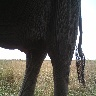

ASG0000a67, Predicted=Animal Correct=Animal


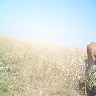

ASG0000ah7, Predicted=Animal Correct=Animal


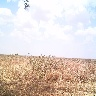

ASG0000eny, Predicted=No animal Correct=No animal


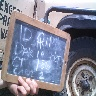

ASG0000vh0, Predicted=Animal Correct=Animal


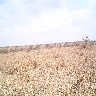

ASG00017tq, Predicted=No animal Correct=No animal


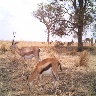

ASG0001ac1, Predicted=Animal Correct=Animal


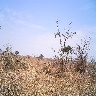

ASG0001dd9, Predicted=No animal Correct=No animal


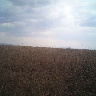

ASG0001rm5, Predicted=No animal Correct=No animal


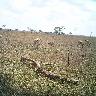

ASG0002hwx, Predicted=No animal Correct=Animal


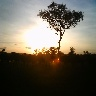

ASG0003ttk, Predicted=Animal Correct=Animal


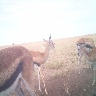

ASG0003v01, Predicted=Animal Correct=Animal


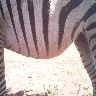

ASG0003xyp, Predicted=Animal Correct=Animal


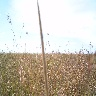

ASG0004l5r, Predicted=No animal Correct=No animal


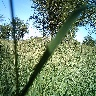

ASG0004p7z, Predicted=No animal Correct=No animal


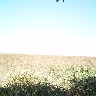

ASG0004xeq, Predicted=No animal Correct=No animal


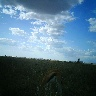

ASG00057fa, Predicted=Animal Correct=Animal


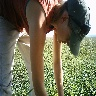

ASG0005nmz, Predicted=Animal Correct=Animal


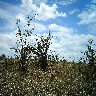

ASG000638i, Predicted=No animal Correct=No animal


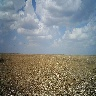

ASG0006anu, Predicted=No animal Correct=No animal


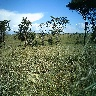

ASG0006v89, Predicted=No animal Correct=No animal


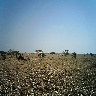

ASG0006z5s, Predicted=Animal Correct=Animal


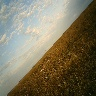

ASG000824z, Predicted=No animal Correct=No animal


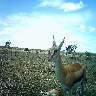

ASG000878a, Predicted=Animal Correct=Animal


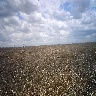

ASG0008qmg, Predicted=No animal Correct=No animal


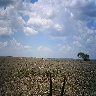

ASG0008tny, Predicted=Animal Correct=Animal


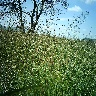

ASG0009f0x, Predicted=No animal Correct=No animal


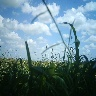

ASG0009hy4, Predicted=No animal Correct=No animal


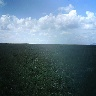

ASG0009rou, Predicted=Animal Correct=No animal


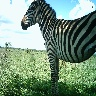

ASG0009v9u, Predicted=Animal Correct=Animal


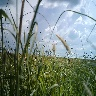

ASG0009z0h, Predicted=No animal Correct=No animal


In [31]:
from IPython.display import Image, display
y_predict = model.predict_classes(X_test[:30])
# show the inputs and predicted outputs
for i in range(len(y_predict)):
    f = images[i] if PREDICT_ONLY else test_data[i] 
    filename = str(f) + ".jpg"
    fullname = os.path.join(image_folder,filename)
    display(Image(filename=fullname))
    interpret_dict = {0:"No animal", 1:"Animal"}
    print("%s, Predicted=%s Correct=%s" % (f, interpret_dict[y_predict[i]], interpret_dict[int(data_dict[f])]))